In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset, TransitionsOnEdge
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
# hparam_file = "gat_hparams"
experiment_name = "GAT_StepLR"

os.mkdir(f"Results/{experiment_name}") if not os.path.isdir(f"Results/{experiment_name}") else ...

Ellipsis

In [6]:
N_datasets = 100

N_sites = 5
N_species = 20
K = 7

N_states = 3**N_sites
print(f"N_states: {N_states}")
generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False, folder="hparam_data")

N_states: 243


'Data already exists'

In [7]:
# dataset = MDPDataset(f"datasets/hparam_data", pre_transform=TransitionsOnEdge())
dataset = InMemoryMDPDataset(f"datasets/hparam_data", pre_transform=TransitionsOnEdge())

/home/james/Repo/MDP-State-Abstraction-CSIRO/Approach_new/gcn_model_multi/dataset.py:125: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_features = torch.Tensor([P[:, i[0], i[1]].numpy() for i in edges])


In [8]:
dataset[0]

Data(x=[243, 5], edges=[2, 2272], edge_features=[2272, 5], k_labels=[243], P=[5, 243, 243], R=[243, 5], V=[243])

In [9]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [10]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)

In [14]:
N_epochs = 5000
results = defaultdict(list)

# torch.cuda.manual_seed(12345)
# {'hidden_channels': 132, 'num_layers': 4, 'dropout': 0.10261264091429285, 'lr': 0.0071256227750093465, 'weight_decay': 0.12567590025587647}

hidden_channels = 132
num_layers = 4
dropout = 0.10261264091429285
lr = 0.004167
weight_decay = 0.12567590025587647

model = GAT(
    in_channels=dataset[0].x.shape[1], 
    out_channels=K, 
    hidden_channels=hidden_channels, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# lr_schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

epochs = tqdm(range(N_epochs))
for epoch in epochs:
    model.train()
    optimizer.zero_grad()     

    loss = 0
    for data in train_data:
        pred = model(
            x = data.x.to(device), 
            edge_index=data.edges.to(device),
            edge_attr = data.edge_features.to(device)
        )
        loss += F.cross_entropy(pred, data.k_labels.to(device))

    loss /= len(train_data) 
    loss.backward()
    optimizer.step()

    results['training_loss'].append(loss.to('cpu').detach().float())


    model.eval()
    test_loss = 0
    avg_gap = 0
    avg_error = 0
    avg_recall = 0
    for data in test_data:
        out = model(
            x = data.x.to(device), 
            edge_index=data.edges.to(device),
            edge_attr = data.edge_features.to(device)
        )
        pred_k = F.softmax(pred, dim=1).argmax(axis=1)
        test_loss += F.cross_entropy(pred, data.k_labels.to(device))#, weight=weights(data.k_labels.to(device), weight_spread))
        # gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
        # avg_gap += gap
        # avg_error += error
        # avg_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")


    test_loss /= len(test_data)
    # avg_gap /= len(test_data)
    # avg_error /= len(test_data)
    # avg_recall /= len(test_data)

    results['test_loss'].append(test_loss.to('cpu').detach().float())
    # results['test_gap'].append(avg_gap)
    # results['test_error'].append(avg_error)
    # results['test_recall'].append(avg_recall)

    epochs.set_description(f"Epoch {epoch+1}/{N_epochs}, Loss {test_loss:.4f}")#, Gap {avg_gap:.4f}, Recall {avg_recall:.4f}")



  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2242/5000, Loss 1.8006:  45%|████▍     | 2242/5000 [10:21<12:44,  3.61it/s]


KeyboardInterrupt: 

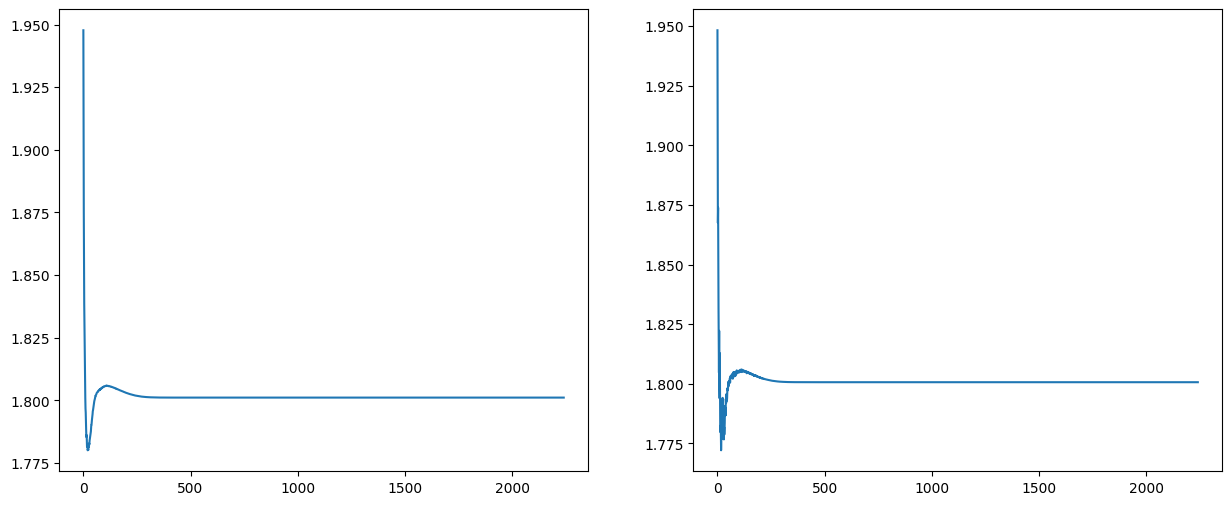

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(results["training_loss"])
ax[1].plot(results['test_loss'])

plt.savefig("NoLRGAT.png")